# SignalSystems
## project 1 : using python to detect road lines
### Bahar Bateni
#### Student ID: 810195563

<ul>notes:
    <li>if you get an "Invalid handle" error, just "restart and run all" the kernel.</li>
    <li>all of the video convert command are commented, due to getting the mentioned error and the fact that they are realy time consuming. uncomment any of them and try "restart and run all"</li>
    <li>this document includes explanations of any method used, steps of getting the final result and any failed attempt that i tried to get a good result. the python file in the root directory named "final.py" has final code, using best method to complete this task.</li>
</ul>

# importing packages
first of all we import packages that we need.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_img
import numpy as np
import cv2

# Reading an image
after that, we should read an image file. the first image we test on, is solidWhiteRight.jpg. after reading it we use pyplot to show it.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


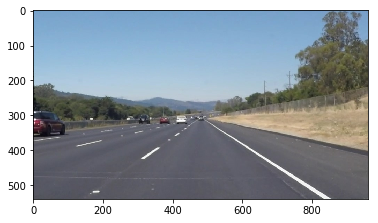

In [2]:
image = mp_img.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)

plt.imshow(image)

# Defining helper functions
we define some helper function to use them as our core mechanism for detecting road lines and showing this lines on the initial image. functions are as follows:
<ul>
    <li>Grayscale: applies the grayscale transformation on an image</li>
    <li>Canny: applies the canny transformation on an image, by getting low and high thresholds. low threshold is used for detecting what is definitely not an edge, and high threshold is used for detecting what is definitely an edge.</li>
    <li>Gaussian Blur: uses gaussian function to apply a blur on image. this will make canny transform to detect edges easier.</li>
    <li>Region of Interest: by getting an image and a set of vertices representing a polygon, keeps that polygon of image, and set all the rest to black pixels.</li>
    <li>Draw Lines: by getting an image and a set of lines, it draw these lines on image. we will not use this function directly but next function we define uses this function.</li>
    <li>Hough Lines: detects lines in an image. then uses draw_lines function to draw these lines on image.</li>
    <li>Weighted Image: by getting two images, transparents them and add them together resulting in one image.</li>
</ul>

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Building my pipeline
## first try
first we will just use three of those functions: canny transform for detecting edges, hough lines for turning these edges to lines, and weighted image for adding lined image to initial image.

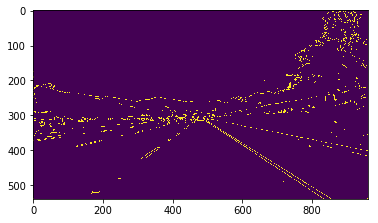

In [4]:
canny_image0 = canny(image, 100, 150) #use canny transform for finding edges of image
plt.imshow(canny_image0) #showing the output

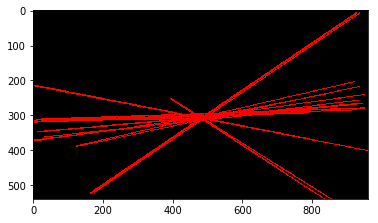

In [5]:
lines_image0 = hough_lines(canny_image0, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
#parameters: source input(output of canny transform), rho(1 pixel), theta(1 degree), threshold, min_line_len, max_line_gap
plt.imshow(lines_image0) #showing the output

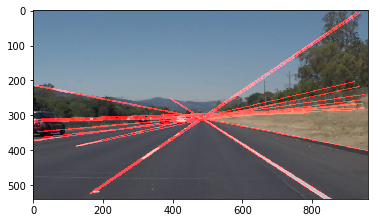

In [6]:
lined_image0 = weighted_img(lines_image0, image) #adding transparent lines image to initial image
plt.imshow(lined_image0) #showing the output

## second try
as the first try had many unwanted lines on it, we use region of intereset for removing those part of picture that we dont want any lines on it. for this purpose, we define a triangle from center of image to bottom left and bottom right corners.

In [7]:
#defining region of interest : a triangle
interest_region = np.array([[[image.shape[1]/2, image.shape[0]/2], [image.shape[1], image.shape[0]], [0, image.shape[0]]]], dtype=np.int32)
interest_region

array([[[480, 270],
        [960, 540],
        [  0, 540]]])

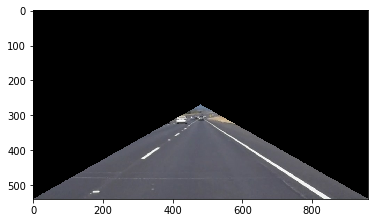

In [8]:
region_image1 = region_of_interest(image, interest_region) #set rest of the picture to black
plt.imshow(region_image1) #showing output

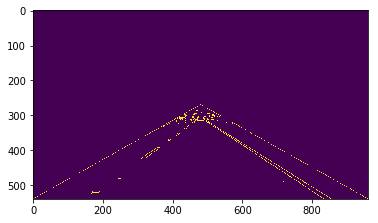

In [9]:
canny_image1 = canny(region_image1, 100, 150) #use canny transform for finding edges of image
plt.imshow(canny_image1) #showing the output

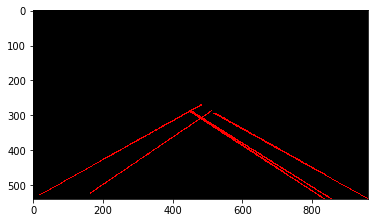

In [10]:
lines_image1 = hough_lines(canny_image1, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
plt.imshow(lines_image1) #showing the output

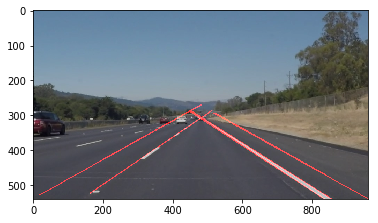

In [11]:
lined_image1 = weighted_img(lines_image1, image) #adding transparent lines image to initial image
plt.imshow(lined_image1) #showing the output

## third try
in the second try, we had two extra lines, because when we used region of interest, between the black parts and other parts, a line was detected. now, we first use canny transfrom and hough lines then region of interest to delete thos extra lines.

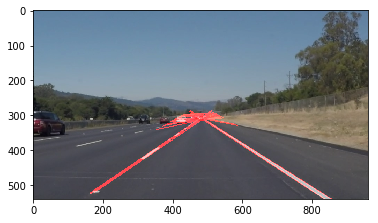

In [12]:
canny_image2 = canny(image, 100, 150) #use canny transform for finding edges of image
lines_image2 = hough_lines(canny_image2, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
region_image2 = region_of_interest(lines_image2, interest_region) #set rest of the picture to black
lined_image2 = weighted_img(region_image2, image) #adding transparent lines image to initial image
plt.imshow(lined_image2) #showing the output

## fourth try
we removed most of the unwanted lines at the third try, but there were still extra lines at the center of image which were partly removed, unlike second try that there were no extra lines except those on the edges of our region of interest. now, we use region of interest two times, first before using canny transform and hughlines, and after that we use it again on a smaller region of interes to delete those two extra lines.

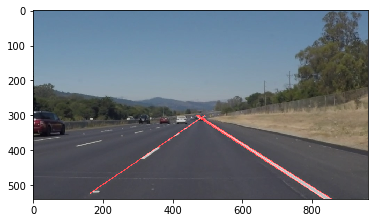

In [13]:
region_image3_0 = region_of_interest(image, interest_region) #set rest of the picture to black
canny_image3 = canny(region_image3_0, 100, 150) #use canny transform for finding edges of image
lines_image3 = hough_lines(canny_image3, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
interest_region_1 = np.array([[[image.shape[1]/2, image.shape[0]/2+25], [image.shape[1]-5, image.shape[0]], [5, image.shape[0]]]], dtype=np.int32)
region_image3_1 = region_of_interest(lines_image3, interest_region_1) #set rest of the picture to black
lined_image3 = weighted_img(region_image3_1, image) #adding transparent lines image to initial image
plt.imshow(lined_image3) #showing the output

## fifth try
now we use grayscale function before using canny transform, because after grayscale transform road lines will be detected better.

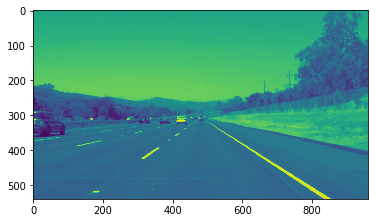

In [14]:
gray_image4 = grayscale(image) #applying grayscale transform
plt.imshow(gray_image4) #showing the output

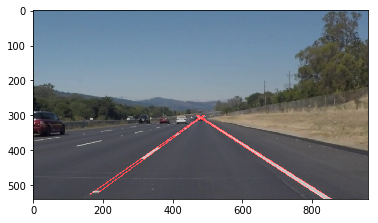

In [15]:
region_image4_0 = region_of_interest(gray_image4, interest_region) #set rest of the picture to black
canny_image4 = canny(region_image4_0, 100, 150) #use canny transform for finding edges of image
lines_image4 = hough_lines(canny_image4, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
region_image4_1 = region_of_interest(lines_image4, interest_region_1) #set rest of the picture to black
lined_image4 = weighted_img(region_image4_1, image) #adding transparent lines image to initial image
plt.imshow(lined_image4) #showing the output

I wanted to try what happens if we dont use two region of interests, and see if grayscale remove some of those extra lines for us.

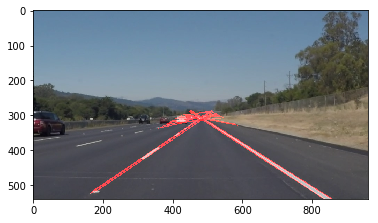

In [16]:
interest_region = np.array([[[image.shape[1]/2, image.shape[0]/2], [image.shape[1], image.shape[0]], [0, image.shape[0]]]], dtype=np.int32)
gray_image4_1 = grayscale(image) #applying grayscale transform
canny_image4_1 = canny(gray_image4_1, 100, 150) #use canny transform for finding edges of image
lines_image4_1 = hough_lines(canny_image4_1, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
region_image4_1_1 = region_of_interest(lines_image4_1, interest_region) #set rest of the picture to black
lined_image4_1 = weighted_img(region_image4_1_1, image) #adding transparent lines image to initial image
plt.imshow(lined_image4_1) #showing the output

the result is not as satisfying as using region of interest two times, so we keep using two region of interests.

## sixth try
we try using gaussian blur before any other function to make it easier for canny transform to detect edges.

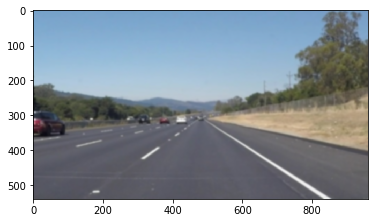

In [17]:
gauss_image5 = gaussian_blur(image,11) #applying gaussian_blur
plt.imshow(gauss_image5) #showing the output

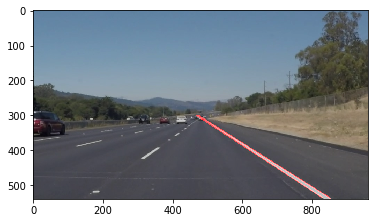

In [18]:
gray_image5 = grayscale(gauss_image5) #applying grayscale transform
region_image5_0 = region_of_interest(gray_image5, interest_region) #set rest of the picture to black
canny_image5 = canny(region_image5_0, 100, 150) #use canny transform for finding edges of image
lines_image5 = hough_lines(canny_image5, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
region_image5_1 = region_of_interest(lines_image5, interest_region_1) #set rest of the picture to black
lined_image5 = weighted_img(region_image5_1, image) #adding transparent lines image to initial image
plt.imshow(lined_image5) #showing the output

because one line is missing, we change gaussian blur and canny transform paremeters as follows:

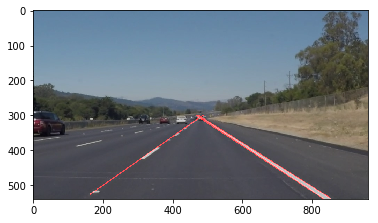

In [19]:
#change parameters of gaussian_blur and canny
gauss_image5 = gaussian_blur(image,5) #applying gaussian_blur
plt.imshow(gauss_image5) #showing the output
gray_image5 = grayscale(gauss_image5) #applying grayscale transform
region_image5_0 = region_of_interest(gray_image5, interest_region) #set rest of the picture to black
canny_image5 = canny(region_image5_0, 10, 150) #use canny transform for finding edges of image
lines_image5 = hough_lines(canny_image5, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
region_image5_1 = region_of_interest(lines_image5, interest_region_1) #set rest of the picture to black
lined_image5 = weighted_img(region_image5_1, image) #adding transparent lines image to initial image
plt.imshow(lined_image5) #showing the output

# Testing on other images
now that are pipeline is working, we use it on other images that we have. first of all we define a function that implemets our sixth pipeline on any given image. then we use that on solidWhiteCurve.jpg and solidYellowCurve.jpg.

In [20]:
def sixth (img):
    gauss_image = gaussian_blur(img,5) #applying gaussian_blur
    gray_image = grayscale(gauss_image) #applying grayscale transform
    region_image_0 = region_of_interest(gray_image, interest_region) #set rest of the picture to black
    canny_image = canny(region_image_0, 10, 150) #use canny transform for finding edges of image
    lines_image = hough_lines(canny_image, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
    region_image_1 = region_of_interest(lines_image, interest_region_1) #set rest of the picture to black
    lined_image = weighted_img(region_image_1, img) #adding transparent lines image to initial image
    plt.imshow(lined_image) #showing the output

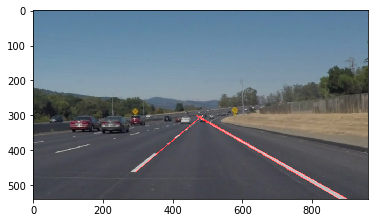

In [21]:
sixth(mp_img.imread('test_images/solidWhiteCurve.jpg'))

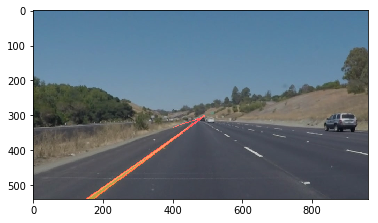

In [22]:
sixth(mp_img.imread('test_images/solidYellowCurve.jpg'))

because we couldn't detect one of the lines in the last image, we test our fifth pipeline on these images.

In [23]:
#the resault is not satisfying
#using fifth try on images:
def fifth (img):
    gray_image = grayscale(img) #applying grayscale transform
    region_image_0 = region_of_interest(gray_image, interest_region) #set rest of the picture to black
    canny_image = canny(region_image_0, 100, 150) #use canny transform for finding edges of image
    lines_image = hough_lines(canny_image, 1, np.pi/180, 90, 1, 1000) #use hough_lines for getting an image of lines
    region_image_1 = region_of_interest(lines_image, interest_region_1) #set rest of the picture to black
    lined_image = weighted_img(region_image_1, img) #adding transparent lines image to initial image
    plt.imshow(lined_image) #showing the output

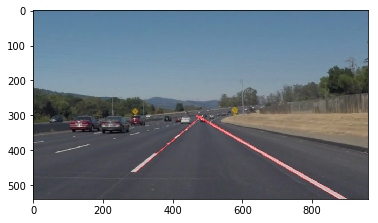

In [24]:
fifth(mp_img.imread('test_images/solidWhiteCurve.jpg'))

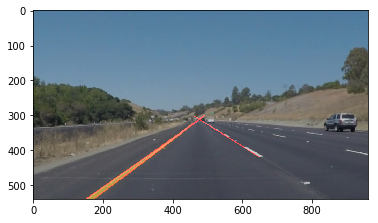

In [25]:
fifth(mp_img.imread('test_images/solidYellowCurve.jpg'))

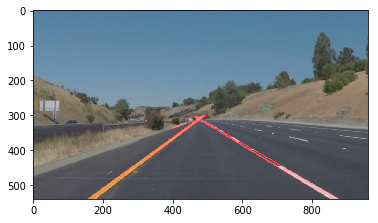

In [26]:
fifth(mp_img.imread('test_images/solidYellowCurve2.jpg'))

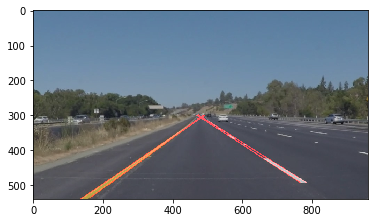

In [27]:
fifth(mp_img.imread('test_images/solidYellowLeft.jpg'))

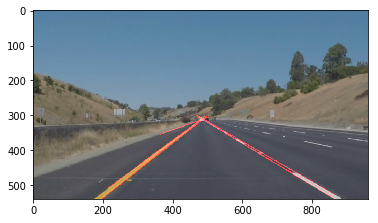

In [28]:
fifth(mp_img.imread('test_images/whiteCarLaneSwitch.jpg'))

# Testing on videos
now that our pipeline works almost satisfying on test images, we should test this function on our videos.

In [29]:
!pip install moviepy

In [30]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def fifth_channel (img):
    gray_image = grayscale(img) #applying grayscale transform
    interest_reg = np.array([[[img.shape[1]/2, img.shape[0]/2], [img.shape[1], img.shape[0]], [0, img.shape[0]]]], dtype=np.int32)
    region_image_0 = region_of_interest(gray_image, interest_reg) #set rest of the picture to black
    canny_image = canny(region_image_0, 100, 110) #use canny transform for finding edges of image
    lines_image = hough_lines(canny_image, 1, np.pi/180, 90, 1, 100) #use hough_lines for getting an image of lines
    interest_reg_1 = np.array([[[img.shape[1]/2, img.shape[0]/2+25], [img.shape[1]-5, img.shape[0]], [5, img.shape[0]]]], dtype=np.int32)
    region_image_1 = region_of_interest(lines_image, interest_reg_1) #set rest of the picture to black
    lined_image = weighted_img(region_image_1, img) #adding transparent lines image to initial image
    return lined_image #showing the output

In [31]:
#video convert function
def video_convert(input_name, channel, out_suf = ''):
    white_output = 'test_videos_output/' + input_name + out_suf + '.mp4'
    clip1 = VideoFileClip("test_videos/" + input_name + ".mp4")
    white_clip = clip1.fl_image(channel) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

In [32]:
#video_convert('solidWhiteRight', fifth_channel)

In [33]:
#video_convert('solidYellowLeft', fifth_channel)

In [34]:
#video_convert('challenge', fifth_channel)

## seventh try
because the resault of detecting road lines in challenge video have some issues, we try other methods:

In [35]:
def seventh_channel (img):
    gray_image = grayscale(img) #applying grayscale transform
    gauss_image = gaussian_blur(gray_image, 15) #use gaussian blur to make it easier for canny to detect edges
    canny_image = canny(gauss_image, 50, 150) #use canny transform for finding edges of image
    interest_reg = np.array([[[img.shape[1]/2, img.shape[0]/2], [img.shape[1], img.shape[0]], [0, img.shape[0]]]], dtype=np.int32)
    interest_reg_1 = np.array([[[img.shape[1]/2, img.shape[0]/2+25], [img.shape[1]-5, img.shape[0]], [5, img.shape[0]]]], dtype=np.int32)
    region_image_0 = region_of_interest(canny_image, interest_reg_1) #set rest of the picture to black
    lines_image = hough_lines(region_image_0, 1, np.pi/180, 20, 20, 300) #use hough_lines for getting an image of lines
    lined_image = weighted_img(lines_image, img) #adding transparent lines image to initial image
    return lined_image #showing the output

In [36]:
#video_convert('challenge', seventh_channel)

## eighth try
we try using another function to mask all parts of the picture that are not white or yellow.
source for idea and implementation of this function:
https://github.com/naokishibuya/car-finding-lane-lines

In [37]:
def select_white_yellow(img):
    converted = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = mask)

def eighth_channel (img):
    white_yellow_image = select_white_yellow(img)
    gray_image = grayscale(white_yellow_image) #applying grayscale transform
    gauss_image = gaussian_blur(gray_image, 15) #use gaussian blur to make it easier for canny to detect edges
    canny_image = canny(gauss_image, 50, 150) #use canny transform for finding edges of image
    interest_reg = np.array([[[img.shape[1]/2, img.shape[0]/2], [img.shape[1], img.shape[0]], [0, img.shape[0]]]], dtype=np.int32)
    interest_reg_1 = np.array([[[img.shape[1]/2, img.shape[0]/2+25], [img.shape[1]-5, img.shape[0]], [5, img.shape[0]]]], dtype=np.int32)
    region_image_0 = region_of_interest(canny_image, interest_reg_1) #set rest of the picture to black
    lines_image = hough_lines(region_image_0, 1, np.pi/180, 20, 20, 300) #use hough_lines for getting an image of lines
    lined_image = weighted_img(lines_image, img) #adding transparent lines image to initial image
    return lined_image #showing the output

In [38]:
#video_convert('challenge', eighth_channel)

## ninth try
now we test this funciton on other images. but first we use select_white_yellow_function on our fifth try:

In [39]:
def ninth_channel (img):
    white_yellow_image = select_white_yellow(img)
    gray_image = grayscale(white_yellow_image) #applying grayscale transform
    interest_reg = np.array([[[img.shape[1]/2, img.shape[0]/2], [img.shape[1], img.shape[0]], [0, img.shape[0]]]], dtype=np.int32)
    region_image_0 = region_of_interest(gray_image, interest_reg) #set rest of the picture to black
    canny_image = canny(region_image_0, 100, 110) #use canny transform for finding edges of image
    lines_image = hough_lines(canny_image, 1, np.pi/180, 90, 1, 100) #use hough_lines for getting an image of lines
    interest_reg_1 = np.array([[[img.shape[1]/2, img.shape[0]/2+25], [img.shape[1]-5, img.shape[0]], [5, img.shape[0]]]], dtype=np.int32)
    region_image_1 = region_of_interest(lines_image, interest_reg_1) #set rest of the picture to black
    lined_image = weighted_img(region_image_1, img) #adding transparent lines image to initial image
    return lined_image #showing the output

In [40]:
#video_convert('challenge', ninth_channel)

# at last
while we got acceptable results for challenge from eighth try, we use it on other videos too. 

In [41]:
#video_convert('solidWhiteRight', eighth_channel)
#video_convert('solidYellowLeft', eighth_channel)
#video_convert('challenge', eighth_channel)

# Beyond the Boundary
just out of curiosity, i tryed using another method. we know that the car may stay in the same line for some time. we use this fact as a new idea: using last frames result with different weights to get result for this frame.
as we masked any color except white and yellow, we draw white lines of last frames in this frame.

In [42]:
def white_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255, 255, 255])
    return line_img

as we see, we cannot work with fl_image function anymore, because this function will create a frame with only that frame's data, and cannot use other frames data.

In [43]:
frames_buffered_test = []

def tenth_channel_test (img):
    frames_buffered_test.append(img)
    ret_image = img
    for i in range(frames_buffered_test.__len__):
        ret_image = weighted_img(frames_buffered_test[i], ret_image)
    return ret_image

#video_convert('solidWhiteRight', tenth_channel_test, '_tenth_test')

we try using fl function instead. first we define a test function for mixing every frame with frames form 2 second ago

In [44]:
def tenth_channel_test2(get_frame, t):
    res = get_frame(t)
    frames = 2
    for i in range(frames):
        res = weighted_img(get_frame(t-i), res, 0.3)
    return res

def video_convert_fl(input_name, channel, out_suf = '', is_sub = False, sub_time = 5):
    white_output = 'test_videos_output/' + input_name + out_suf + '.mp4'
    clip1 = VideoFileClip("test_videos/" + input_name + ".mp4")
    if is_sub:
        clip1 = clip1.subclip(0,sub_time)
    white_clip = clip1.fl(channel) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

In [45]:
#video_convert_fl('solidWhiteRight', tenth_channel_test2, '_tenth_test2', True, 3)

then we run the actual tenth method:

In [50]:
def tenth_channel (img, get_white=False):
    white_yellow_image = select_white_yellow(img)
    gray_image = grayscale(white_yellow_image) #applying grayscale transform
    gauss_image = gaussian_blur(gray_image, 15) #use gaussian blur to make it easier for canny to detect edges
    canny_image = canny(gauss_image, 50, 150) #use canny transform for finding edges of image
    interest_reg = np.array([[[img.shape[1]/2, img.shape[0]/2], [img.shape[1], img.shape[0]], [0, img.shape[0]]]], dtype=np.int32)
    interest_reg_1 = np.array([[[img.shape[1]/2, img.shape[0]/2+25], [img.shape[1]-5, img.shape[0]], [5, img.shape[0]]]], dtype=np.int32)
    region_image_0 = region_of_interest(canny_image, interest_reg_1) #set rest of the picture to black
    if get_white:
        return white_hough_lines(region_image_0, 1, np.pi/180, 20, 20, 300) #use hough_lines for getting an image of lines
    else:
        lines_image = hough_lines(region_image_0, 1, np.pi/180, 20, 20, 300) #use hough_lines for getting an image of lines
    lined_image = weighted_img(lines_image, img) #adding transparent lines image to initial image
    return lined_image

def tenth_channel_fl_sub(get_frame, t):
    res = get_frame(t)
    frames = 2
    for i in range(frames):
        res = weighted_img(tenth_channel(get_frame(t-i), True), res, 0.3)
    return weighted_img(res, get_frame(t))

In [51]:
#video_convert_fl('solidWhiteRight', tenth_channel_fl_sub, '_tenth_sub', True, 3)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_tenth_sub.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_tenth_sub.mp4


 99%|█████████████████████████████████████████▍| 75/76 [00:20<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_tenth_sub.mp4 

Wall time: 20.8 s


as we expected, we the lines are bolder now.
then, we use this method on all images, and not subclips of them. this will take some time.

In [52]:
def tenth_channel_fl(get_frame, t):
    res = get_frame(t)
    frames = 2
    for i in range(frames):
        res = weighted_img(tenth_channel(get_frame(t-i), True), res, 0.3)
    return tenth_channel(weighted_img(res, get_frame(t)))

In [53]:
#video_convert_fl('solidWhiteRight', tenth_channel_fl, '_tenth')

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_tenth.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_tenth.mp4


100%|███████████████████████████████████████▊| 221/222 [01:06<00:00,  3.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_tenth.mp4 

Wall time: 1min 6s


In [54]:
#video_convert_fl('solidYellowLeft', tenth_channel_fl, '_tenth')

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_tenth.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_tenth.mp4


100%|███████████████████████████████████████▉| 681/682 [03:18<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_tenth.mp4 

Wall time: 3min 19s


In [55]:
#video_convert_fl('challenge', tenth_channel_fl, '_tenth')

[MoviePy] >>>> Building video test_videos_output/challenge_tenth.mp4
[MoviePy] Writing video test_videos_output/challenge_tenth.mp4


100%|████████████████████████████████████████| 251/251 [02:12<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_tenth.mp4 

Wall time: 2min 13s


by changing the frame parameter in "tenth_channel_fl" function, we may get even better results. but it will be even more time consuming.